<img src = "images/Logo.png" width = 220, align = "left">

<h1 align=center><font size = 6><span style="color:blue">Feature Selection</span></font></h1>
<h2 align=center><font size = 5>Lab Exercise 3.15</font></h2>
<h3 align=center><font size = 4><b>Advanced Machine Learning Made Easy<br></b><small>From Theory to Practice with NumPy and scikit-learn<br><i>Volume 1: Generalized Linear Models</i></font></h3>

## Introduction

In this lab exercise, we will analyze different methods for feature selection in order to decrease the complexity of the model, and by this, its variance providing a simpler and more interpretable model. 

The following feature selection methods will be discussed: 
- filter methods, also called univariate feature selection, based on techniques like feature importance, low variance threshold, Chi-squared, and F-test, respective the mutual information
- wrapper methods, also called (feature) subset selection, like best subset selection, forward and backward stepwise selection 
- embedded methods, like shrinkage, will be discussed in a separate lab exercise, namely, Lab Exercise 3.16 Regularization

**Note**: *The source of the "Boston House-price" dataset can be found at http://lib.stat.cmu.edu/datasets/boston. However, we will use the built-in method of the scikit-learn library to obtain this dataset.*

**Note: This lab exercise requires scikit-learn version of at least 0.24!**

### Table of contents
1. [Feature selection based on feature importance](#FeatureImportance)
2. [Filtering with a low variance threshold](#LowVariance)
3. [Filtering with Chi-squared test](#Ch2)
4. [Filtering based on F-test](#Ftest)
5. [Filtering based on mutual information](#MI)
6. [Best subset selection](#BestSubset)
7. [Forward stepwise selection](#Forward)
8. [Backward stepwise selection](#Backward)
9. [Stepwise selection with cross-validation](#StepwiseCV)
10. [Model selection with information criteria](#InfoCriteria)

## 1. Feature selection based on feature importance <a name="FeatureImportance"></a>

In the case of the univariate feature selection method, the individual input variables are ranked according to specific criteria (a numeric scoring technique to quantify the strength of the relationship between the individual predictor and target).  Then the filtering (i.e., feature selection) can be done by either selecting the $M<D$ highest scored features or selecting a given percentile of the total features by picking the highest scored ones. 

As a first step, let's import the required libraries and set the matplotlib for making plots inline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols, logit
import seaborn as sns
import os
%matplotlib inline

Let's load the King County House Sale dataset and create the necessary feature transformation implemented in Lab Exercise 3.14.

In [2]:
data = pd.read_csv(os.path.join('data','HouseSalesKingCounty.csv'))
data['date']=pd.to_datetime(data['date'])
data['spring_summer']=data.date.dt.month.apply(lambda x: 1 if x in [3,4,5,6,7] else 0)
data['renovated']=data['yr_renovated'].apply(lambda x: 1 if x>0 else 0)
data['age']=2017-data['yr_built']

Let's fit the OLS model again and print the results.

In [3]:
numvar_list=['sqft_living','sqft_lot','sqft_above','sqft_living15','sqft_lot15','age','bedrooms','bathrooms',\
             'lat','long','zipcode']
catvar_list=['view','condition','grade','waterfront','renovated','spring_summer']
formula='price ~ ' + ' + '.join(numvar_list) +' + ' + ' + '.join(catvar_list)
model_ols = ols(formula = formula, data=data).fit()
print(model_ols.summary(title="OLS Regression Results (all predictors)"))
print("RMSE =",np.sqrt(model_ols.mse_resid))

                   OLS Regression Results (all predictors)                    
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2967.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:00:59   Log-Likelihood:            -2.9459e+05
No. Observations:               21613   AIC:                         5.892e+05
Df Residuals:                   21595   BIC:                         5.894e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.978e+05   2.84e+06      0.210

As a reminder, we found a model having almost the same goodness of fit but only half the features used in the model.

In [4]:
numvar_shortlist=numvar_list.copy()
numvar_shortlist.remove('sqft_above')
numvar_shortlist.remove('sqft_living15')
numvar_shortlist.remove('sqft_lot15')
numvar_shortlist.remove('sqft_lot')
numvar_shortlist.remove('zipcode')
numvar_shortlist.remove('long')
catvar_shortlist=catvar_list.copy()
catvar_shortlist.remove('condition')
catvar_shortlist.remove('renovated')
catvar_shortlist.remove('spring_summer')

formula='price ~ ' + ' + '.join(numvar_shortlist) +' + ' + ' + '.join(catvar_shortlist)

model_ols1 = ols(formula = formula, data=data).fit()
print(model_ols1.summary(title="OLS Regression Results (reduced number of predictors)"))
print("RMSE =",np.sqrt(model_ols1.mse_resid))

            OLS Regression Results (reduced number of predictors)             
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     6013.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:00:59   Log-Likelihood:            -2.9495e+05
No. Observations:               21613   AIC:                         5.899e+05
Df Residuals:                   21604   BIC:                         5.900e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.705e+07   4.93e+05    -54.859      

So far, so good! But we know from the lab exercise 3.14 Generalization Error that we should use cross-validation for estimating the future performance of the linear regression model. So let's define again the pipeline with preprocessing and linear regression.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression

from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin,BaseEstimator

class AgeTransf(BaseEstimator, TransformerMixin):
    def __init__(self,baseyear=2017):
        self.baseyear=baseyear
        return
    def fit(self, X, y = None):
        return self
    def transform(self, x, y = None):
        return self.baseyear-x
    def inverse_transform(self, x, y = None):
        return self.baseyear-x

myAgeTransf=AgeTransf(2017)
ct = ColumnTransformer(transformers=[('agetransf',myAgeTransf,['yr_built'])],remainder='passthrough')
ct.fit_transform(data[['yr_built']])

numeric_features = ['sqft_living', 'yr_built','lat','bedrooms','bathrooms']
yrbuilt_transformer = ColumnTransformer(transformers=[('agetransf',myAgeTransf,['yr_built'])],remainder='passthrough')
numeric_transformer = Pipeline(steps=[
    ('age_transf', yrbuilt_transformer),
    ('scaler', StandardScaler())])
categorical_features = ['waterfront','view','grade']
categorical_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)], remainder='drop')

regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

Then fit the model using the selected predictors.

In [6]:
from sklearn import set_config
set_config(display='diagram')

regr.fit(data, data['price'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('age_transf',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('agetransf',
                                                                                                    AgeTransf(),
                                                                                                    ['yr_built'])])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sqft_living', 'yr_built',
                                                   'lat', 'bedrooms',
                                                   'bathrooms']),
                                                 ('cat', 'passthrough',
                                                  ['waterfront', 'view',
                                                   'grade'])])),
                ('regressor', LinearRegression())])

Finally, print out the mean of the score values using K-fold cross-validation (with K=5).

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, r2_score

mse_scorer=make_scorer(score_func=mean_squared_error,greater_is_better=False)
r2_scorer=make_scorer(score_func=r2_score,greater_is_better=True)

cv_result=\
cross_validate(estimator=regr,X=data,y=data['price'],scoring={'MSE':mse_scorer,'R2':r2_scorer},cv=5, return_train_score=False)
print('Mean R2 =',np.mean(cv_result['test_R2']))
print('Mean RMSE =',np.mean(np.sqrt(-cv_result['test_MSE'])))

Mean R2 = 0.6863323059510114
Mean RMSE = 205229.01412007437


Let's use the scikit-learn library to fit the linear regression model then select the features based on their respective regression coefficient value (i.e., feature importance). Set the threshold to the median, so half of the features will be selected (features with the highest regression coefficient will be chosen).

In [8]:
from sklearn.feature_selection import SelectFromModel,RFE,RFECV
from sklearn.linear_model import LinearRegression
linregr=LinearRegression()
sfm=SelectFromModel(estimator=linregr,threshold='median')
sfm.fit(data[numvar_list+catvar_list],data[['price']])

SelectFromModel(estimator=LinearRegression(), threshold='median')

List out the selected features based on feature importance (i.e., regression coefficient value).

In [9]:
list(np.array(numvar_list+catvar_list)[sfm.get_support()])

['bedrooms',
 'bathrooms',
 'lat',
 'long',
 'view',
 'condition',
 'grade',
 'waterfront',
 'renovated']

Let's check the threshold used in the selection (median value of the regression coefficients).

In [10]:
sfm.threshold_

26103.809375663153

We can create a bar chart for all the regression coefficients arranged in descending order.

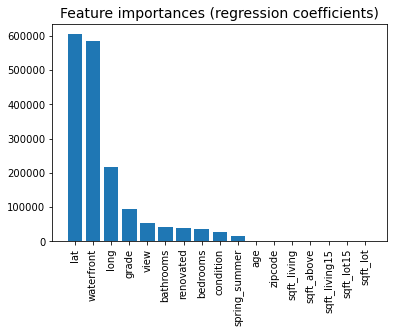

In [11]:
importance = np.abs(np.squeeze(sfm.estimator_.coef_))
idx=np.argsort(importance)
feature_names = np.array(numvar_list+catvar_list)
plt.bar(height=importance[idx][::-1], x=feature_names[idx][::-1])
plt.title("Feature importances (regression coefficients)",fontsize=14)
plt.xticks(rotation = 90)
plt.show()

Let's set a higher absolute threshold value to select only seven features and list out the names of those features.

In [12]:
sfm=SelectFromModel(estimator=linregr,threshold=38000)
sfm.fit(data[numvar_list+catvar_list],data[['price']])
list(np.array(numvar_list+catvar_list)[sfm.get_support()])

['bathrooms', 'lat', 'long', 'view', 'grade', 'waterfront', 'renovated']

Using k-fold cross-validation, check the estimated generalization error of a linear regression model with those predictors.

In [13]:
cv_result=\
cross_validate(estimator=linregr,X=data[list(np.array(numvar_list+catvar_list)[sfm.get_support()])],y=data['price'],\
               scoring={'MSE':mse_scorer,'R2':r2_scorer},cv=5, return_train_score=False)
print('Mean R2 =',np.mean(cv_result['test_R2']))
print('Mean RMSE =',np.mean(np.sqrt(-cv_result['test_MSE'])))

Mean R2 = 0.5954342695003705
Mean RMSE = 233130.9634056245


We may choose a different strategy in selecting the features bases on the regression coefficients (feature importance). That is the so-called recursive feature elimination, which starts by fitting a model with all the features. Then removes the one with the lowest regression coefficient (feature importance). Next, a linear model using the remaining predictors is fitted, and the one with the lowest feature importance (regression coefficient) is discarded. The feature elimination stops when the desired number of features remains in the model. 

In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
linregr=LinearRegression()
rfe=RFE(estimator=linregr,n_features_to_select=7,verbose=1)
rfe.fit(data[numvar_list+catvar_list],data[['price']])

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


RFE(estimator=LinearRegression(), n_features_to_select=7, verbose=1)

Let's print out the selected features.

In [15]:
list(np.array(numvar_list+catvar_list)[rfe.support_])

['bathrooms', 'lat', 'long', 'view', 'grade', 'waterfront', 'renovated']

As can be seen, the same result is obtained as before.

We may use an automatic selection of the minimum number of features by using the K-fold cross-validation during recursive feature elimination based on the score value of the linear regression, namely the R-squared value.

In [16]:
min_features_to_select = 1
rfe_cv=RFECV(estimator=linregr,min_features_to_select=min_features_to_select,cv=5,verbose=1)
rfe_cv.fit(data[numvar_list+catvar_list],data[['price']])

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitt

RFECV(cv=5, estimator=LinearRegression(), verbose=1)

Let's print out the selected features.

In [17]:
list(np.array(numvar_list+catvar_list)[rfe_cv.support_])

['sqft_living',
 'sqft_above',
 'age',
 'bedrooms',
 'bathrooms',
 'lat',
 'long',
 'zipcode',
 'view',
 'condition',
 'grade',
 'waterfront',
 'renovated',
 'spring_summer']

We can print out the optimal number of features.

In [18]:
rfe_cv.n_features_

14

Let's plot the cross-validation score (R-squared value) vs. the number of features selected.

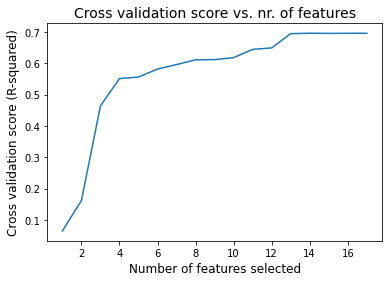

In [19]:
plt.figure()
plt.plot(range(min_features_to_select,len(rfe_cv.grid_scores_)+min_features_to_select),rfe_cv.grid_scores_)
plt.xlabel("Number of features selected",fontsize=12)
plt.ylabel("Cross validation score (R-squared)",fontsize=12)
plt.title("Cross validation score vs. nr. of features",fontsize=14)
plt.show()

Based on the cross-validation with R-squared scoring, the number of features is 14. That should not be a surprise, as the R-squared value always increases with at least a very small value with every addition of a new feature. 

## 2. Filtering with a low variance threshold <a name="LowVariance"></a>

In the case of the univariate feature selection method, the individual input variables are ranked according to a specific criterion (a numeric scoring technique to quantify the strength of the relationship between the individual predictor and target).  Then the filtering (feature selection) can be done by either selecting the $M<D$ highest scored features or selecting a given percentile of the total features by picking the highest scored ones. 

As a first step, let's import the required libraries and set the matplotlib for making plots inline.

### Low variance threshold for regression

This technique is based on calculating the variance of each predictor.
Then based on a low threshold, discard those features that have zero variance or quasi zero variance (i.e., those features that should not have any effect or only a very minor on the target).

Let's see how the number of features is decreased if we use low variance thresholding. Because the threshold is range-dependent, we should apply min-max scaling first so the values of all features will be in the range of $[0,1]$. 

**Note:** *That can be done whether the variable is numerical or categorical with ordinal encoding - see the book for an explanation. * 

Then calculate the variance of each feature and arrange them in descending order. Finally, print out the first eight predictors. (respective the remaining ones).

In [20]:
variance=(((data[numvar_list+catvar_list]-data[numvar_list+catvar_list].min())/\
(data[numvar_list+catvar_list].max()-data[numvar_list+catvar_list].min())).var())
variance.sort_values(ascending=False)

spring_summer    0.249988
zipcode          0.073023
age              0.065240
lat              0.049675
renovated        0.040503
view             0.036703
condition        0.026467
sqft_living15    0.013912
long             0.013681
grade            0.009595
bathrooms        0.009268
sqft_above       0.008245
waterfront       0.007485
sqft_living      0.004805
sqft_lot15       0.000984
bedrooms         0.000794
sqft_lot         0.000630
dtype: float64

As can be seen, the 'spring_summer' variable has the highest variance, although we know that the correlation with the target is very low. By setting the variance threshold to 0.01, in which case, nine predictors will be selected.<br>
Let's create the bar chart of the variance of the scaled predictors arranged in descending order.

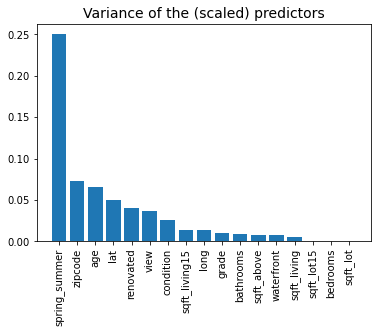

In [21]:
idx=np.argsort(np.array(variance))
feature_names = np.array(numvar_list+catvar_list)
plt.bar(height=np.array(variance)[idx][::-1], x=feature_names[idx][::-1])
plt.title("Variance of the (scaled) predictors",fontsize=14)
plt.xticks(rotation = 90)
plt.show()

Based on the variance threshold, the input matrix will become:

In [22]:
varlist=(((data[numvar_list+catvar_list]-data[numvar_list+catvar_list].min())/\
(data[numvar_list+catvar_list].max()-data[numvar_list+catvar_list].min())).var()).sort_values(ascending=False)[:9]
data[list(varlist.index)]

,spring_summer,zipcode,age,lat,renovated,view,condition,sqft_living15,long
0,0,98178,62,47.5112,0,0,3,1340,-122.257
1,0,98125,66,47.7210,1,0,3,1690,-122.319
2,0,98028,84,47.7379,0,0,3,2720,-122.233
3,0,98136,52,47.5208,0,0,5,1360,-122.393
4,0,98074,30,47.6168,0,0,3,1800,-122.045
...,...,...,...,...,...,...,...,...,...
21608,1,98103,8,47.6993,0,0,3,1530,-122.346
21609,0,98146,3,47.5107,0,0,3,1830,-122.362
21610,1,98144,8,47.5944,0,0,3,1020,-122.299
21611,0,98027,13,47.5345,0,0,3,1410,-122.069


These predictors are not the ones, which we selected earlier. Let's print out the OLS results using these features for comparison.

In [23]:
formula='price ~ '+' + '.join(list(varlist.index))
model_ols = ols(formula = formula, data=data).fit()
print(model_ols.summary(title="OLS Regression Results (reduced number of predictors)"))
print("RMSE =",np.sqrt(model_ols.mse_resid))

            OLS Regression Results (reduced number of predictors)             
Dep. Variable:                  price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     2475.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:01:05   Log-Likelihood:            -2.9995e+05
No. Observations:               21613   AIC:                         5.999e+05
Df Residuals:                   21603   BIC:                         6.000e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.655e+07   3.58e+06     -7.422

As can be seen, the variance threshold did not provide a good feature selection for this particular problem.

The input matrix can be obtained easily using the *scikit-learn* library.

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
scaler=MinMaxScaler()
var_selector=VarianceThreshold(threshold=0.01)
var_selector.fit_transform(scaler.fit_transform(data[numvar_list+catvar_list]))

array([[0.16193426, 0.52173913, 0.57149751, ..., 0.5       , 0.        ,
        0.        ],
       [0.22216486, 0.55652174, 0.90895931, ..., 0.5       , 1.        ,
        0.        ],
       [0.3994149 , 0.71304348, 0.93614283, ..., 0.5       , 0.        ,
        0.        ],
       ...,
       [0.10686629, 0.05217391, 0.70532411, ..., 0.5       , 0.        ,
        1.        ],
       [0.17398038, 0.09565217, 0.60897539, ..., 0.5       , 0.        ,
        0.        ],
       [0.10686629, 0.06086957, 0.70484156, ..., 0.5       , 0.        ,
        0.        ]])

The calculated variances are the same as what we obtained earlier.

In [25]:
np.sort(var_selector.variances_)[::-1][:,np.newaxis]

array([[0.24997662],
       [0.07301947],
       [0.06523685],
       [0.04967263],
       [0.04050097],
       [0.03670097],
       [0.02646543],
       [0.0139109 ],
       [0.01368066],
       [0.00959472],
       [0.00926756],
       [0.00824416],
       [0.00748488],
       [0.00480453],
       [0.00098368],
       [0.00079428],
       [0.00062951]])

Now, let's see how does it perform in K-fold cross-validation. First, we create a new pipeline, which 
- scales all the features with a min-max scaler;
- selects the (scaled) predictors with low-variance thresholding;
- then fit a linear regression model.

In [26]:
regr1 = Pipeline(steps=[('postprocessor', scaler),
                        ('filter', var_selector),
                        ('regressor', LinearRegression())])

Let's fit the defined pipeline on the data.

In [27]:
regr1.fit(data[numvar_list+catvar_list], data['price'])

Pipeline(steps=[('postprocessor', MinMaxScaler()),
                ('filter', VarianceThreshold(threshold=0.01)),
                ('regressor', LinearRegression())])

Finally, print out the mean of the scoring values (RMSE and R-squared) obtained with K-fold cross-validation.

In [28]:
cv_result=\
cross_validate(estimator=regr1,X=data[numvar_list+catvar_list],y=data['price'],scoring={'MSE':mse_scorer,'R2':r2_scorer},\
               cv=5, return_train_score=False)
print('Mean R2 =',np.mean(cv_result['test_R2']))
print('Mean RMSE =',np.mean(np.sqrt(-cv_result['test_MSE'])))

Mean R2 = 0.5537922458682285
Mean RMSE = 244811.78659728583


As can be seen, the test score values are worse than what we have seen using the training set (whole dataset), even if we use one more predictor.

**Note:** *When encoded as ordinal ones, the variance can be calculated on categorical variables, too. That applies even if the categorical variable is nominal. For an explanation, see the book.*

### Low variance threshold for classification

The variance threshold filtering is better performing in the case of classification (when the target is categorical).

**Note:** *Even though the classification will be discussed in Chapter 6, we should discuss the feature selection here for completeness. *

Let's take another example, the famous iris dataset.

In [29]:
from sklearn import datasets
iris = datasets.load_iris()
iris_data=pd.DataFrame(data=iris.data,columns=iris.feature_names)
iris_data['species']=iris.target
iris_data['species']=\
iris_data['species'].apply(lambda x: iris.target_names[0] if x==0 else iris.target_names[1] if x==1 else iris.target_names[2])
iris_data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


And apply logistic regression using the *scikit-learn* library. Then print out the score of the prediction.

**Note:** *Logistic regression will be discussed in the lab exercises related to chapter 6. The below classification score values reach their best value at 1 and worst score at 0.*

In [30]:
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(penalty='none',multi_class='multinomial')
clf.fit(iris.data,iris.target)
y_score = clf.predict_proba(iris.data)
y_pred = clf.predict(iris.data)
y=iris.target
print("F1-score =",f1_score(y, y_pred,average='micro'))
print("ROC-AUC score =",roc_auc_score(y, y_score,multi_class='ovo'))

F1-score = 0.9866666666666668
ROC-AUC score = 0.9990666666666668


Let's estimate the future prediction performance with K-fold cross-validation.

In [31]:
f1_scorer=make_scorer(score_func=f1_score,greater_is_better=True, average='micro')
roc_auc_scorer=make_scorer(score_func=roc_auc_score,greater_is_better=True,needs_proba=True,multi_class='ovo')

cv_result=\
cross_validate(estimator=clf,X=iris.data,y=iris.target,scoring={'F1-score':f1_scorer,'ROC-AUC-score':roc_auc_scorer},cv=5)
print('Mean F1-score =',np.mean(cv_result['test_F1-score']))
print('Mean ROC-AUC score =',np.mean(cv_result['test_ROC-AUC-score']))

Mean F1-score = 0.9733333333333334
Mean ROC-AUC score = 0.9964999999999999


The score results are similar. Now, using the variance threshold filtering, let's print out the shape of the input matrix.

In [32]:
var_selector.set_params(threshold=0.05)
X_reduced=var_selector.fit_transform(scaler.fit_transform(iris.data))
X_reduced.shape

(150, 3)

As can be seen, one input feature is dropped out of the four. Let's print out the score values after fitting the logistic regression on the reduced feature set.

In [33]:
clf.fit(X_reduced,iris.target)
y_score = clf.predict_proba(X_reduced)
y_pred = clf.predict(X_reduced)
print("F1-score =",f1_score(y, y_pred,average='micro'))
print("ROC-AUC score =",roc_auc_score(y, y_score,multi_class='ovo'))

F1-score = 0.98
ROC-AUC score = 0.9982666666666665


The scoring values are the same using the full dataset. Thus, in this case, the variance threshold filtering is working. Let's check this with the K-fold cross-validation.

In [34]:
cv_result=\
cross_validate(estimator=clf,X=X_reduced,y=iris.target,scoring={'F1-score':f1_scorer,'ROC-AUC-score':roc_auc_scorer},cv=5)
print('Mean F1-score =',np.mean(cv_result['test_F1-score']))
print('Mean ROC-AUC score =',np.mean(cv_result['test_ROC-AUC-score']))

Mean F1-score = 0.9666666666666668
Mean ROC-AUC score = 0.9973333333333333


As can be observed, even with K-fold cross-validation, the score values are almost the same. So using a low variance threshold - which keeps only three quarters from the total number of predictors - will provide a model with almost the same performance.

## 3. Filtering with Chi-squared test <a name="Ch2"></a>

The Chi-squared test can only be used for feature selection when the output is categorical, i.e., for the classification task. From Lab Exercise 3.7 Encoding Categorical Features, we know that the Chi-squared test is used for testing statistical independence between categorical variables (that is, we test how the target is statistically dependent with each predictor).

### Chi-squared test for categorical features

For this purpose, let's consider a new dataset that has only categorical predictors, and the goal is to predict whether the breast cancer recurrence event happens or not based on the available predictors.

In [35]:
col_names=['class','age','menopause','tumor','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']
breast=pd.read_csv(os.path.join('data','breast-cancer.data'),names=col_names)
breast

,class,age,menopause,tumor,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


Let's check the unique values in each predictor, respective the target (the first variable in the list).

In [36]:
for name in col_names:
    print('Unique values for',(name,np.sort(breast[name].unique())))

Unique values for ('class', array(['no-recurrence-events', 'recurrence-events'], dtype=object))
Unique values for ('age', array(['20-29', '30-39', '40-49', '50-59', '60-69', '70-79'], dtype=object))
Unique values for ('menopause', array(['ge40', 'lt40', 'premeno'], dtype=object))
Unique values for ('tumor', array(['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '5-9', '50-54'], dtype=object))
Unique values for ('inv-nodes', array(['0-2', '12-14', '15-17', '24-26', '3-5', '6-8', '9-11'],
      dtype=object))
Unique values for ('node-caps', array(['?', 'no', 'yes'], dtype=object))
Unique values for ('deg-malig', array([1, 2, 3], dtype=int64))
Unique values for ('breast', array(['left', 'right'], dtype=object))
Unique values for ('breast-quad', array(['?', 'central', 'left_low', 'left_up', 'right_low', 'right_up'],
      dtype=object))
Unique values for ('irradiat', array(['no', 'yes'], dtype=object))


As can be seen, there are two predictors that have '?' values, which are denoting missing values. Let's use the simple imputer with the most frequent imputation strategy.

In [37]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(missing_values='?',strategy='most_frequent')
breast['node-caps']=imputer.fit_transform(np.array(breast['node-caps']).reshape(-1, 1))
breast['breast-quad']=imputer.fit_transform(np.array(breast['breast-quad']).reshape(-1, 1))
for name in col_names:
    print('Unique values for',(name,np.sort(breast[name].unique())))

Unique values for ('class', array(['no-recurrence-events', 'recurrence-events'], dtype=object))
Unique values for ('age', array(['20-29', '30-39', '40-49', '50-59', '60-69', '70-79'], dtype=object))
Unique values for ('menopause', array(['ge40', 'lt40', 'premeno'], dtype=object))
Unique values for ('tumor', array(['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '5-9', '50-54'], dtype=object))
Unique values for ('inv-nodes', array(['0-2', '12-14', '15-17', '24-26', '3-5', '6-8', '9-11'],
      dtype=object))
Unique values for ('node-caps', array(['no', 'yes'], dtype=object))
Unique values for ('deg-malig', array([1, 2, 3], dtype=int64))
Unique values for ('breast', array(['left', 'right'], dtype=object))
Unique values for ('breast-quad', array(['central', 'left_low', 'left_up', 'right_low', 'right_up'],
      dtype=object))
Unique values for ('irradiat', array(['no', 'yes'], dtype=object))


Let's create a list with the feature names.

In [38]:
feature_names=col_names.copy()
feature_names.remove('class')
feature_names

['age',
 'menopause',
 'tumor',
 'inv-nodes',
 'node-caps',
 'deg-malig',
 'breast',
 'breast-quad',
 'irradiat']

Let's define the Chi-square function that will take as input only categorical features.

In [39]:
from scipy.stats import chi2_contingency
def chi2_cat(X,y):
    X=np.array(X)
    chi2_val=[]
    p_val=[]
    _,D=X.shape
    for j in range(D):
        chi2_result=chi2_contingency(pd.crosstab(index=y,columns=X[:,j],margins=False))
        chi2_val.append(chi2_result[0])
        p_val.append(chi2_result[1])
    return np.array(chi2_val),np.array(p_val)

And print out the $\chi^2$ score values and the associated $p$ values.

In [40]:
res=chi2_cat(X=breast[feature_names],y=breast['class'])
res

(array([ 3.99773945,  0.79145992, 17.91574586, 28.79974965, 20.41189528,
        31.69495607,  0.74329926,  3.6655091 ,  9.78061509]),
 array([5.49741462e-01, 6.73188460e-01, 5.64016297e-02, 6.63812796e-05,
        6.24404706e-06, 1.31077376e-07, 3.88606054e-01, 4.53162285e-01,
        1.76361307e-03]))

Let's create the bar chart with the $\chi^2$ score values of the features arranged in descending order.

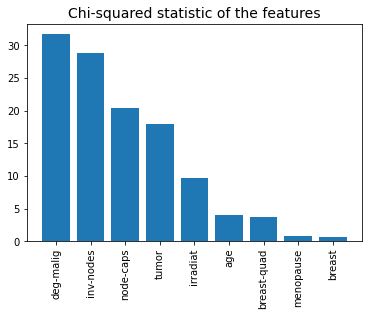

In [41]:
plt.bar(range(9),res[0][np.argsort(res[0])[::-1]])
plt.xticks(range(9),np.array(feature_names)[np.argsort(res[0])][::-1],rotation=90)
plt.title("Chi-squared statistic of the features",fontsize=14)
plt.show()

Let's print out the logistic regression results using the *statsmodels* library. We may use the *scikit-learn* library for encoding ordinal variables.

In [42]:
from sklearn.preprocessing import OrdinalEncoder
enc=OrdinalEncoder()
def xx(x):
    return enc.fit_transform(np.array(x).reshape(-1,1))

logit_res=logit(formula = 'xx(Q("class")) ~ xx(age) + C(menopause) + xx(tumor) + xx(Q("inv-nodes")) + \
Q("node-caps") + Q("deg-malig")+breast + Q("breast-quad") + irradiat', data = breast).fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.523894
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         xx(Q("class"))   No. Observations:                  286
Model:                          Logit   Df Residuals:                      272
Method:                           MLE   Df Model:                           13
Date:                Mon, 15 Nov 2021   Pseudo R-squ.:                  0.1390
Time:                        21:01:07   Log-Likelihood:                -149.83
converged:                       True   LL-Null:                       -174.02
Covariance Type:            nonrobust   LLR p-value:                 5.637e-06
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -3.5098      1.120     -3.133      0.

The prediction table, also called the confusion matrix, has the following values. The diagonal predictions are the good ones, while the off-diagonal elements are the erroneous predictions.

**Note:** *Confusion matrix will be discussed in Chapter 6 of the book.*

In [43]:
logit_res.pred_table()

array([[187.,  14.],
       [ 53.,  32.]])

The accuracy of the prediction can be calculated as the sum of good predictions divided by the total sum of predictions.

In [44]:
print('Accuracy =',np.sum(np.diag(logit_res.pred_table()))/np.sum(logit_res.pred_table()))

Accuracy = 0.7657342657342657


Now, let's do the same, but at this time, use only the first four predictors, based on the highest $\chi^2$ statistic.

In [45]:
logit_res=logit(formula = 'xx(Q("class")) ~ xx(tumor) + xx(Q("inv-nodes")) + Q("node-caps") + Q("deg-malig")'\
                , data = breast).fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.534918
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         xx(Q("class"))   No. Observations:                  286
Model:                          Logit   Df Residuals:                      281
Method:                           MLE   Df Model:                            4
Date:                Mon, 15 Nov 2021   Pseudo R-squ.:                  0.1209
Time:                        21:01:07   Log-Likelihood:                -152.99
converged:                       True   LL-Null:                       -174.02
Covariance Type:            nonrobust   LLR p-value:                 1.609e-08
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.0995      0.540     -5.737      0.000      -4.158      -2.

And print out again the prediction table.

In [46]:
logit_res.pred_table()

array([[184.,  17.],
       [ 56.,  29.]])

A small decrease in good prediction can be seen. Let's see the prediction accuracy.

In [47]:
print('Accuracy =',np.sum(np.diag(logit_res.pred_table()))/np.sum(logit_res.pred_table()))

Accuracy = 0.7447552447552448


As can be observed, only a minor decrease in the accuracy can be seen.<br> 
In what follows, we will implement this feature selection using the *scikit-learn* library.

In [48]:
from sklearn.preprocessing import OneHotEncoder

logregr=LogisticRegression(penalty='none',solver='newton-cg')
enc=OrdinalEncoder()
onehot=OneHotEncoder(drop='first',sparse=False)

binary_features = ['node-caps','breast','irradiat']
ordinal_features = ['age','tumor','inv-nodes']
nominal_features = ['menopause','breast-quad']

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', enc, binary_features),
        ('ordinal', enc, ordinal_features),
        ('nominal', onehot, nominal_features),
        ('numerical','passthrough',['deg-malig'])], remainder='drop')

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', logregr)])
y=enc.fit_transform(np.array(breast['class']).reshape(-1,1)).ravel()
pipe.fit(breast, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary', OrdinalEncoder(),
                                                  ['node-caps', 'breast',
                                                   'irradiat']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['age', 'tumor',
                                                   'inv-nodes']),
                                                 ('nominal',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['menopause', 'breast-quad']),
                                                 ('numerical', 'passthrough',
                                                  ['deg-malig'])])),
                ('regressor',
                 LogisticRegression(penalty='none', solver='newton-cg'))])

We considered in the data preprocessing step the "deg-malig" predictor as a numerical one just because it is already encoded. <br>
Now, let's print out the intercept.

In [49]:
pipe['regressor'].intercept_

array([-3.50979529])

respective the regression coefficients:

In [50]:
encoded_features=binary_features + ordinal_features + ['menopause:lt40','menopause:premeno',] + \
['breast-quad:left_low','breast-quad:left_up','breast-quad:right_low','breast-quad:right_up'] + ['deg-malig']
for i in range(pipe['regressor'].coef_.shape[1]):
    print('%s : %f} '%(encoded_features[i],pipe['regressor'].coef_[0,i]))

node-caps : 0.366995} 
breast : -0.312664} 
irradiat : 0.387170} 
age : 0.010861} 
tumor : 0.057372} 
inv-nodes : 0.171914} 
menopause:lt40 : 0.839373} 
menopause:premeno : 0.361043} 
breast-quad:left_low : 0.315476} 
breast-quad:left_up : 0.087199} 
breast-quad:right_low : -0.071833} 
breast-quad:right_up : 0.687758} 
deg-malig : 0.771192} 


Now, print out the confusion matrix.

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y,pipe.predict(breast))

array([[187,  14],
       [ 53,  32]], dtype=int64)

respective, the accuracy score:

In [52]:
from sklearn.metrics import accuracy_score
accuracy_scorer=make_scorer(score_func=accuracy_score,greater_is_better=True)
accuracy_score(y,pipe.predict(breast))

0.7657342657342657

So far, so good. The results from the *scikit-learn* library match with the ones obtained with the *statsmodels* library.

Let's check the generalization performance with k-fold cross-validation (with K=10).

In [53]:
X=preprocessor.fit_transform(breast)

cv_result=\
cross_validate(estimator=logregr,X=X,y=y,scoring={'Accuracy':accuracy_scorer,'ROC-AUC-score':roc_auc_scorer},cv=10)
print('Mean Accuracy =',np.mean(cv_result['test_Accuracy']))
print('Mean ROC-AUC score =',np.mean(cv_result['test_ROC-AUC-score']))

Mean Accuracy = 0.71564039408867
Mean ROC-AUC score = 0.6745436507936506


Now, let's see the classification result if we select only the first four features with the highest Chi-squared values.

In [54]:
from sklearn.feature_selection import SelectKBest

ch2_scorer=make_scorer(score_func=chi2_cat,greater_is_better=True)

kbest=SelectKBest(score_func=chi2_cat,k=4)
kbest.fit_transform(X,y)

array([[0., 5., 0., 3.],
       [0., 3., 0., 2.],
       [0., 3., 0., 2.],
       ...,
       [0., 3., 0., 1.],
       [0., 5., 4., 3.],
       [0., 5., 4., 3.]])

The same result can be obtained when the percentile of the features to be selected is given (instead of setting the number of features).

In [55]:
from sklearn.feature_selection import SelectPercentile
percent=SelectPercentile(score_func=chi2_cat,percentile=30)
percent.fit_transform(X,y)

array([[0., 5., 0., 3.],
       [0., 3., 0., 2.],
       [0., 3., 0., 2.],
       ...,
       [0., 3., 0., 1.],
       [0., 5., 4., 3.],
       [0., 5., 4., 3.]])

Print out the mean of the score values using the K-fold cross-validation.

In [56]:
cv_result=\
cross_validate(estimator=logregr,X=kbest.fit_transform(X,y),y=y,\
               scoring={'Accuracy':accuracy_scorer,'ROC-AUC-score':roc_auc_scorer},cv=10)
print('Mean Accuracy =',np.mean(cv_result['test_Accuracy']))
print('Mean ROC-AUC score =',np.mean(cv_result['test_ROC-AUC-score']))

Mean Accuracy = 0.733743842364532
Mean ROC-AUC score = 0.7179464285714285


As can be seen, the overall generalization performance is slightly better with the reduced feature set.

**Note:** *The "chi2" filter from the "scikit-learn" library is a one-way Chi-square test. Thus, it cannot be used for categorical variables only for numerical ones representing frequency values. For more explanation, see the book. We may take a try to see the result of such a feaure selection.*

In [57]:
from sklearn.feature_selection import chi2

enc=OrdinalEncoder()
X=breast[feature_names]
X=enc.fit_transform(X)
y=enc.fit_transform(np.array(breast['class']).reshape(-1,1))

res=chi2(X,y)
res

(array([ 0.56328394,  0.71237775,  5.53435737, 84.84098477, 17.62117563,
        13.27275466,  0.52277506,  0.42523187,  8.19724561]),
 array([4.52940113e-01, 3.98655583e-01, 1.86466122e-02, 3.23351785e-20,
        2.69569985e-05, 2.69291222e-04, 4.69660314e-01, 5.14337922e-01,
        4.19540337e-03]))

We need to encode all categorical variables, whether they are nominal or not, using ordinal encoding in order to use the chi2 function from the scikit-learn library. The first array contains the $\chi^2$ statistics, while the second array the associated p-values.

Again, create the bar chart of the features with the $\chi^2$ scores arranged in descending order.

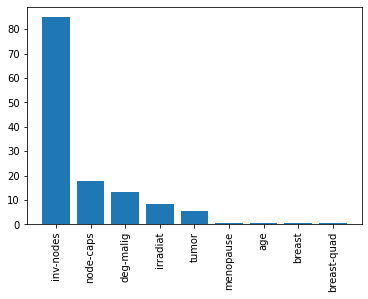

In [58]:
plt.bar(range(9),res[0][np.argsort(res[0])[::-1]])
plt.xticks(range(9),np.array(feature_names)[np.argsort(res[0])][::-1],rotation=90)
plt.show()

As can be seen, the $\chi^2$ score values are different in the two cases. The reason is straightforward. For each binary variable or nominal variable with one-hot encoding, you have a contingency table with two columns, one for zero values and the other one for ones. But with the one-way Chi-square test, the frequency values corresponding to zero values will not be counted. That leads to different results. In the case of categorical variables with more than two categories encoded as ordinal ones, it is even worst because, in addition, frequency values from the contingency table will be multiplied by the ordinal number of the category. 

### Chi-squared test for numerical features

The *chi2* method from *scikit-learn* library can be used only for numerical values when these represent some meaningful frequency values. Let's use the "iris" dataset again, although the numerical values are not frequency values per se.

In [59]:
X, y = datasets.load_iris(return_X_y=True)
chi2(X,y)

(array([ 10.81782088,   3.7107283 , 116.31261309,  67.0483602 ]),
 array([4.47651499e-03, 1.56395980e-01, 5.53397228e-26, 2.75824965e-15]))

If we encode the output in a one-vs-all fashion, this result can be obtained easily.

In [60]:
from sklearn.preprocessing import LabelBinarizer
Y=LabelBinarizer().fit_transform(y)
Y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

Next, calculate the observed values. That is not a contingency table but an input to the one-way chi-square test each time using only one column out of the four.

In [61]:
observed = Y.T@X
observed

array([[250.3, 171.4,  73.1,  12.3],
       [296.8, 138.5, 213. ,  66.3],
       [329.4, 148.7, 277.6, 101.3]])

We may take the sum of each row

In [62]:
np.sum(Y.T@X,axis=1,keepdims=True)

array([[507.1],
       [714.6],
       [857. ]])

respective the sum of each column:

In [63]:
feature_count = X.sum(axis=0).reshape(1, -1)
feature_count

array([[876.5, 458.6, 563.7, 179.9]])

Finally the total sum is

In [64]:
np.sum(Y.T@X)

2078.7

Let's calculate the class probabilities (in the case of binary variables encoded as 0 and 1, this is equal to the mean value).

In [65]:
class_prob = Y.mean(axis=0).reshape(1, -1)
class_prob

array([[0.33333333, 0.33333333, 0.33333333]])

Based on the class probabilities, we can calculate the expected values.

In [66]:
expected = class_prob.T@feature_count
expected

array([[292.16666667, 152.86666667, 187.9       ,  59.96666667],
       [292.16666667, 152.86666667, 187.9       ,  59.96666667],
       [292.16666667, 152.86666667, 187.9       ,  59.96666667]])

Then the $\chi^2$ statistics are:

In [67]:
np.sum((observed-expected)**2/expected,axis=0)

array([ 10.81782088,   3.7107283 , 116.31261309,  67.0483602 ])

Using the *scipy* library, we can easily get both the $\chi^2$ scores, as well as the associated p-values.

In [68]:
from scipy.stats import chisquare
chisquare(observed,expected)

Power_divergenceResult(statistic=array([ 10.81782088,   3.7107283 , 116.31261309,  67.0483602 ]), pvalue=array([4.47651499e-03, 1.56395980e-01, 5.53397228e-26, 2.75824965e-15]))

As a final step, use the K-fold cross-validation again and print out the mean of the score values.

In [69]:
kbest=SelectKBest(score_func=chi2,k=3)

cv_result=\
cross_validate(estimator=clf,X=kbest.fit_transform(X,y),y=iris.target,\
               scoring={'F1-score':f1_scorer,'ROC-AUC-score':roc_auc_scorer},cv=5)
print('Mean F1-score =',np.mean(cv_result['test_F1-score']))
print('Mean ROC-AUC score =',np.mean(cv_result['test_ROC-AUC-score']))

Mean F1-score = 0.9666666666666668
Mean ROC-AUC score = 0.9973333333333333


As can be observed, the Chi2-squared filtering provided a good job, similarly to the variance threshold technique.

## 4. Filtering based on F-test <a name="Ftest"></a>

In the case of regression (i.e., with numerical output variable), the F-test reduces to filtering based on the correlation coefficient between each feature and target.

### F-test for regression

Let's consider the King County House Sale dataset again. <br>
Here is the correlation matrix.

In [70]:
data.drop(['id','date'],axis=1).corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,spring_summer,renovated,age
price,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,...,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447,0.033033,0.126092,-0.054012
bedrooms,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,...,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244,0.011219,0.018553,-0.154178
bathrooms,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,...,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175,0.008337,0.050260,-0.506019
sqft_living,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,...,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286,0.009644,0.055094,-0.318049
sqft_lot,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,...,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557,-0.003931,0.007745,-0.053080
floors,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,...,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269,0.004901,0.006260,-0.489319
waterfront,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,...,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703,-0.003517,0.093294,0.026161
view,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,...,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575,-0.000179,0.104062,0.053440
condition,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,...,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406,-0.000325,-0.060139,0.361417
grade,0.667434,0.356967,0.664983,0.762704,0.113621,0.458183,0.082775,0.251321,-0.144674,1.000000,...,0.446963,0.014414,-0.184862,0.114084,0.198372,0.713202,0.119248,0.016679,0.014008,-0.446963


The correlation coefficients between the target and each feature arranged in descending order are provided here.

In [71]:
correlations=data.drop(['id','date'],axis=1).corr().loc['price'][1:]
correlations.abs().sort_values()[::-1]

sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
renovated        0.126092
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
age              0.054012
zipcode          0.053203
condition        0.036362
spring_summer    0.033033
long             0.021626
Name: price, dtype: float64

Let's visualize this with a bar chart with features arranged in descending order based on the F-statistic.

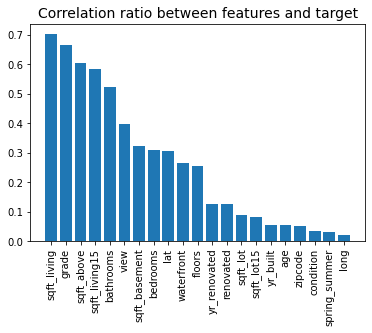

In [72]:
plt.bar(range(correlations.size),correlations.abs().sort_values()[::-1])
plt.xticks(range(correlations.size),list((correlations.abs().sort_values()[::-1]).index),rotation=90)
plt.title("Correlation ratio between features and target",fontsize=14)
plt.show()

The same result can be obtained using the *scikit-learn* library.

In [73]:
from sklearn.feature_selection import f_regression
res=f_regression(X=data.drop(['id','date','price'],axis=1),y=data['price'])
res

(array([2.27065523e+03, 8.22894319e+03, 2.10019094e+04, 1.75140301e+02,
        1.52570610e+03, 1.65046304e+03, 4.05045896e+03, 2.86114585e+01,
        1.73606352e+04, 1.25140607e+04, 2.53150635e+03, 6.32290366e+01,
        3.51074842e+02, 6.13445108e+01, 2.24881468e+03, 1.01120686e+01,
        1.12658645e+04, 1.47906884e+02, 2.36070635e+01, 3.49150112e+02,
        6.32290366e+01]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 7.97252025e-040,
        1.58101007e-322, 0.00000000e+000, 0.00000000e+000, 8.93563854e-008,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.92988381e-015,
        1.02134574e-077, 5.01106974e-015, 0.00000000e+000, 1.47509403e-003,
        0.00000000e+000, 6.41756871e-034, 1.18980532e-006, 2.64014329e-077,
        1.92988381e-015]))

Again, the upper array contains the F-test values while the lower array the associated $p$ values. 

We can create the bar chart where features are arranged with F-statistic values in descending order.

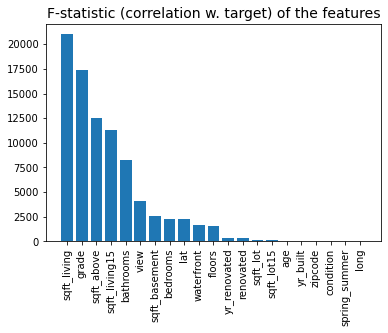

In [74]:
feature_names=list(data.drop(['id','date','price'],axis=1).columns)
plt.bar(range(len(feature_names)),res[0][np.argsort(res[0])[::-1]])
plt.xticks(range(len(feature_names)),np.array(feature_names)[np.argsort(res[0])][::-1],rotation=90)
plt.title("F-statistic (correlation w. target) of the features",fontsize=14)
plt.show()

The F-test can be calculated easily from the correlation coefficients.

In [75]:
N=data.shape[0]
r=correlations.abs().sort_values()[::-1]
Ftest=r**2*(N-2)/(1-r**2)
Ftest

sqft_living      21001.909384
grade            17360.635177
sqft_above       12514.060692
sqft_living15    11265.864467
bathrooms         8228.943192
view              4050.458960
sqft_basement     2531.506350
bedrooms          2270.655230
lat               2248.814682
waterfront        1650.463040
floors            1525.706098
yr_renovated       351.074842
renovated          349.150112
sqft_lot           175.140301
sqft_lot15         147.906884
yr_built            63.229037
age                 63.229037
zipcode             61.344511
condition           28.611459
spring_summer       23.607064
long                10.112069
Name: price, dtype: float64

Now, let's take the first seven features with the highest F-scores and, using K-fold cross-validation, check the performance of the linear model using these predictors.

In [76]:
kbest=SelectKBest(score_func=f_regression,k=7)

cv_result=\
cross_validate(estimator=regr,X=data.drop(['id','date','price'],axis=1),y=data['price'],\
                                          scoring={'MSE':mse_scorer,'R2':r2_scorer},cv=5, return_train_score=False)
print('Mean R2 =',np.mean(cv_result['test_R2']))
print('Mean RMSE =',np.mean(np.sqrt(-cv_result['test_MSE'])))

Mean R2 = 0.6863323059510114
Mean RMSE = 205229.01412007437


The goodness-of-fit values are close to what we had with all the features. However, we also know that 'sqft_living' is highly correlated with 'sqft_above', 'sqft_basement', and 'sqft_living15'. Moreover "sqft_living=sqft_basement+sqft_above" by definition, so we have a serious multicollinearity issue.

**Note:** *The correlation coefficient, thus the F-test, reflects the linear relationship between the target and the features. If this relation is not linear, the Pearson correlation coefficient might not be a good score. We also know that the Pearson correlation coefficient is lower than other types of correlation coefficients in the case of categorical features.*

### F-test for classification

The F-test for classification can be used only when all the predictors are numerical. It is based on the one-way ANOVA test, where the means of the numerical feature belonging to different output categories (groups) are compared.

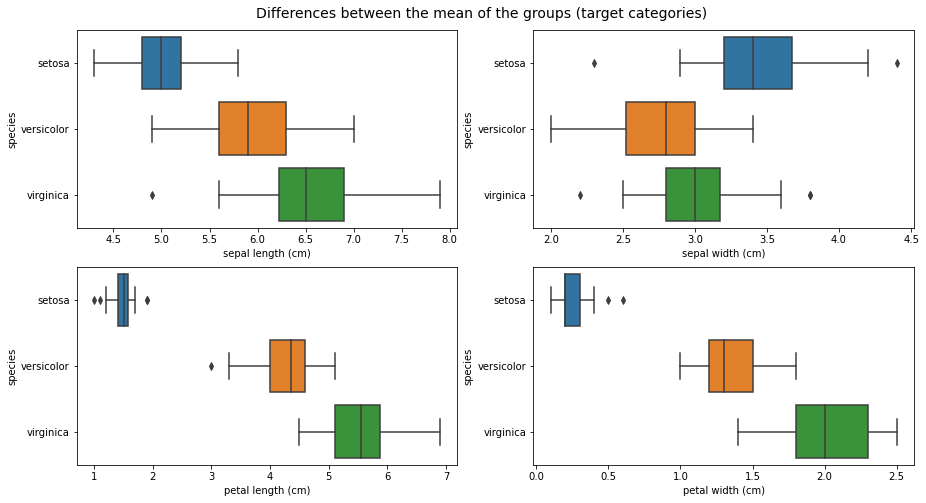

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(y='species',x='sepal length (cm)',data=iris_data,ax=ax[0,0])
sns.boxplot(y='species',x='sepal width (cm)',data=iris_data,ax=ax[0,1])
sns.boxplot(y='species',x='petal length (cm)',data=iris_data,ax=ax[1,0])
sns.boxplot(y='species',x='petal width (cm)',data=iris_data,ax=ax[1,1])
plt.suptitle("Differences between the mean of the groups (target categories)",fontsize=14,y=0.92)
plt.show()

With the one-way ANOVA test, we test whether the means of the groups are all equal (H0 hypothesis) or at least two of them are different (H1 hypothesis). If we cannot reject H0, then the given feature does not provide any hint on the output categories. If H0 can be rejected, then the given predictor can (at least partly) explain the differences between the groups (i.e., the differences between output categories).

Let's calculate the one-way ANOVA F-test for each feature. First, we group the *pandas* dataframe according to the iris species and take the mean of each feature belonging to a group.

In [78]:
X_k=iris_data.groupby('species').mean()
X_k

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


The above table contains the mean of each feature belonging to a given output category (class). There are three output categories (classes) and four features, so we have a 3x4 matrix.<br> 
Let's also count the number of observations for each group.

In [79]:
N_k=iris_data.groupby('species').count()
N_k

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
species,,,,
setosa,50,50,50,50
versicolor,50,50,50,50
virginica,50,50,50,50


The above matrix contains the number of observations for each class and each feature. <br>
Create the mean vector as the overall mean of each feature (so-called grand mean in ANOVA).

In [80]:
mu_=X.mean(axis=0,keepdims=True).T
mu_

array([[5.84333333],
       [3.05733333],
       [3.758     ],
       [1.19933333]])

Let's calculate the Sum of Squares Between-groups using the formula from the book.

In [81]:
SSB=np.sum(N_k*(X_k-mu_.T)**2,axis=0)
SSB

sepal length (cm)     63.212133
sepal width (cm)      11.344933
petal length (cm)    437.102800
petal width (cm)      80.413333
dtype: float64

The Mean Squares Between-group can be obtained by dividing the SSB by the degree of freedom (number of groups minus one).

In [82]:
K=len(iris_data['species'].unique())
MSB=np.array(SSB/(K-1))
MSB

array([ 31.60606667,   5.67246667, 218.5514    ,  40.20666667])

Similarly, let's calculate the Sum of Squares Between-groups using the formula from the book. 

In [83]:
SSW=np.array([(np.array((iris_data.groupby('species').get_group(types).drop(columns=['species'])-X_k.loc[types]))**2)\
              .sum(axis=0) for types in ['setosa','versicolor','virginica']]).sum(axis=0)
SSW

array([38.9562, 16.962 , 27.2226,  6.1566])

The Mean Squares Within-groups is obtained by dividing SSW by the degree of freedom (number of observations minus number of groups).

In [84]:
N,_=iris_data.shape
MSW=SSW/(N-K)
MSW

array([0.26500816, 0.11538776, 0.18518776, 0.04188163])

Finally, the F-values can be obtained by dividing the Mean Square Between-groups with the Mean Square Within-groups.

In [85]:
MSB/MSW

array([ 119.26450218,   49.16004009, 1180.16118225,  960.0071468 ])

The same result can be obtained using the "f-classif" method from the *scikit-learn* library.

In [86]:
from sklearn.feature_selection import f_classif
f_classif(iris.data,iris.target)

(array([ 119.26450218,   49.16004009, 1180.16118225,  960.0071468 ]),
 array([1.66966919e-31, 4.49201713e-17, 2.85677661e-91, 4.16944584e-85]))

Next, check the performance of the model using K-fold cross-validation with K=5.

In [87]:
kbest=SelectKBest(score_func=f_classif,k=3)

cv_result=\
cross_validate(estimator=clf,X=kbest.fit_transform(X,y),y=iris.target,\
               scoring={'F1-score':f1_scorer,'ROC-AUC-score':roc_auc_scorer},cv=5)
print('Mean F1-score =',np.mean(cv_result['test_F1-score']))
print('Mean ROC-AUC score =',np.mean(cv_result['test_ROC-AUC-score']))

Mean F1-score = 0.9666666666666668
Mean ROC-AUC score = 0.9973333333333333


As can be noticed, this technique performed the filtering well, just like the low variance threshold and Chi-square test.

## 5. Filtering based on mutual information <a name="MI"></a>

Mutual information is a measure of dependencies between two random variables. It captures the idea of the "amount of information" one random variable carries about the other.

### Mutual information for regression

The mutual information is estimated between the continuous target and features. Categorical features may also be present.

Let's use again the King County House Sale dataset.

In [88]:
from sklearn.feature_selection import mutual_info_regression
res=mutual_info_regression(X=data.drop(['id','date','price'],axis=1),y=data['price'])
res

array([0.08311682, 0.20684079, 0.35146889, 0.06174143, 0.07621025,
       0.00570148, 0.05133083, 0.01251595, 0.34110365, 0.26406736,
       0.0703103 , 0.07291694, 0.0051717 , 0.41663085, 0.34190181,
       0.11628536, 0.26856049, 0.08254195, 0.00593782, 0.00821844,
       0.07218049])

Next, for visualizing the result, let's create the bar chart with features arranged in descending order based on the mutual information with the target.

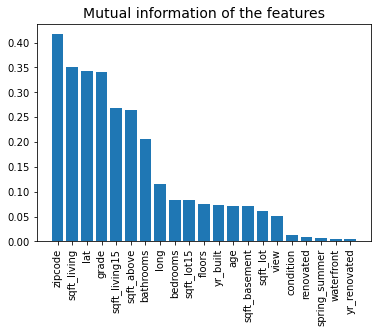

In [89]:
feature_names=list(data.drop(['id','date','price'],axis=1).columns)
plt.bar(range(len(feature_names)),res[np.argsort(res)[::-1]])
plt.xticks(range(len(feature_names)),np.array(feature_names)[np.argsort(res)][::-1],rotation=90)
plt.title("Mutual information of the features",fontsize=14)
plt.show()

Finally, check the model performance with the reduced features using K-fold cross-validation with K=5.

In [90]:
kbest=SelectKBest(score_func=mutual_info_regression,k=7)

cv_result=\
cross_validate(estimator=regr,X=data.drop(['id','date','price'],axis=1),y=data['price'],\
                                          scoring={'MSE':mse_scorer,'R2':r2_scorer},cv=5, return_train_score=False)
print('Mean R2 =',np.mean(cv_result['test_R2']))
print('Mean RMSE =',np.mean(np.sqrt(-cv_result['test_MSE'])))

Mean R2 = 0.6863323059510114
Mean RMSE = 205229.01412007437


Although the goodness-of-fit scores are close to the values that we obtained using all features, we can observe that the correlation coefficient between 'sqft_living' and 'sqft_above', respective between 'sqft_living' and 'sqft_living15' is high. Thus, high multicollinearity issue arises using this filtering method.

### Mutual information for classification

Similarly, we can define mutual information between categorical target and categorical features (although numerical features may also be present). 

For this, we consider the breast cancer recurrence dataset presented earlier and calculate the mutual information between the categorical target and each categorical feature (using ordinal encoding).

In [91]:
from sklearn.feature_selection import mutual_info_classif

feature_names=col_names.copy()
feature_names.remove('class')
X=enc.fit_transform(breast[feature_names])
y=enc.fit_transform(np.array(breast['class']).reshape(-1, 1))

res=mutual_info_classif(X,np.squeeze(y))
res

array([0.        , 0.        , 0.06326833, 0.03719059, 0.05449107,
       0.01123851, 0.        , 0.        , 0.        ])

For visualization purposes, create the bar chart of the features arranged in descending order based on the mutual information with the target.

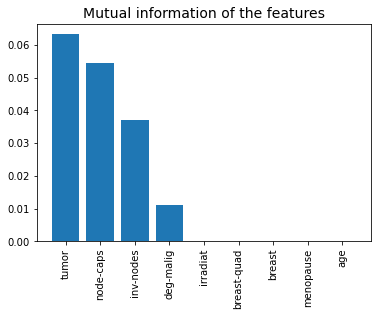

In [92]:
plt.bar(range(len(feature_names)),res[np.argsort(res)[::-1]])
plt.xticks(range(len(feature_names)),np.array(feature_names)[np.argsort(res)][::-1],rotation=90)
plt.title("Mutual information of the features",fontsize=14)
plt.show()

Finally, check the model performance using K-fold cross-validation with K=10.

In [93]:
X=preprocessor.fit_transform(breast)
kbest=SelectKBest(score_func=mutual_info_classif,k=4)

cv_result=\
cross_validate(estimator=logregr,X=kbest.fit_transform(X,np.squeeze(y)),y=np.squeeze(y),\
               scoring={'Accuracy':accuracy_scorer,'ROC-AUC-score':roc_auc_scorer},cv=10)
print('Mean Accuracy =',np.mean(cv_result['test_Accuracy']))
print('Mean ROC-AUC score =',np.mean(cv_result['test_ROC-AUC-score']))

Mean Accuracy = 0.7300492610837439
Mean ROC-AUC score = 0.7136359126984128


## 6. Best subset selection <a name="BestSubset"></a>

As we have observed, univariate feature selection, while in the case of logistic regression (classification) works with some limitations, fails in the case of multiple linear regression. 

To overcome this problem, one option is to search for all possible combinations of the input variables (i.e., fit models using all combinations of the features) and choose the model which provides the highest adjusted R-squared value. This is the so-called wrapper method.

**Note:** *it is important to use adjusted R-squared value because some offset is needed for increasing the number of features.*

Let's load the Boston house price dataset from the *scikit-learn* library.

In [94]:
from sklearn.datasets import load_boston
bostondict=load_boston()
boston=pd.DataFrame(bostondict['data'],columns=bostondict['feature_names'])
boston['PRICE']=bostondict['target']
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Let's create a function calculating the adjusted R-square. Make it compatible with the *scikit-learn* scorer method that can be used in cross-validation.

In [95]:
from sklearn.metrics import r2_score
def R2_adj_scorer(estimator,X,y):
    N,D=X.shape
    estimator.fit(X,y)
    r2=estimator.score(X,y)
    r2_adj=1-(1-r2)*(N-1)/(N-D-1)
    return r2_adj

We can check the adjusted R-squared function by calculating for the full model containing all predictors.

In [96]:
linregr=LinearRegression()
R2_adj_scorer(linregr,boston.drop(['PRICE'],axis=1),boston['PRICE'])

0.733789726372463

and compare the obtained value with the OLS result from the *statsmodels* library.

In [97]:
model = ols(formula = 'PRICE ~ CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+B+LSTAT', data=boston).fit()
print(model.summary(title='Linear regression with all the predictors'))
print("\nRMSE =",np.sqrt(model.mse_resid))

                  Linear regression with all the predictors                   
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 15 Nov 2021   Prob (F-statistic):          6.72e-135
Time:                        21:01:16   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

Let's calculate the adjusted R-square value of the models using all possible combinations of the features.

In [98]:
from itertools import combinations

scorehist=[]
N,_=boston.shape
features=boston.drop(['PRICE'],axis=1).columns
D=len(features)

# Calculate the adjusted R-squared value for the model with zero features (mean of the output)
y=boston['PRICE']
y_mean=y.mean()*np.ones(N)
r2=r2_score(y,y_mean)
r2_adj=1-(1-r2)*(N-1)/(N-D-1) if 1-(1-r2)*(N-1)/(N-D-1)>=0 else 0 # if it is negative set to zero


print('For %d variables '%0,end='')
print("the highest adj-R2 is =",r2_adj)
print()
scorehist.append([r2_adj])

sum_models=1
R2_maxvals=[r2_adj]

for i in range(1,D+1):                    # loop for number of variables included
    R2_max=0
    index=0
    scores=[]
    for idx in combinations(range(D),i):  # loop for the combination of variables for a given number of features
        sum_models+=1
        score=R2_adj_scorer(linregr,boston[features[list(idx)]],y)
        scores.append(score)              # Save all the scores
        if score>R2_max:
            R2_max=score
            index=idx
    R2_maxvals.append(R2_max)             # Save the maximum value
    scorehist.append(scores)
    print('For %d variables '%i,end='')
    print("the lowest RMSE value is =",R2_max)
    print('\tfor variables',list(boston.columns[list(index)]))
    print()
print("Total number of model fit:",sum_models)

For 0 variables the highest adj-R2 is = 0

For 1 variables the lowest RMSE value is = 0.543241825954707
	for variables ['LSTAT']

For 2 variables the lowest RMSE value is = 0.6371244754701231
	for variables ['RM', 'LSTAT']

For 3 variables the lowest RMSE value is = 0.6767035874132712
	for variables ['RM', 'PTRATIO', 'LSTAT']

For 4 variables the lowest RMSE value is = 0.6878351084841281
	for variables ['RM', 'DIS', 'PTRATIO', 'LSTAT']

For 5 variables the lowest RMSE value is = 0.7051701822464959
	for variables ['NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']

For 6 variables the lowest RMSE value is = 0.712356667191387
	for variables ['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']

For 7 variables the lowest RMSE value is = 0.7182560407158509
	for variables ['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT']

For 8 variables the lowest RMSE value is = 0.7222071804094558
	for variables ['ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT']

For 9 variables the lowest RMSE value is = 0

As can be seen, the total number of model fitting is high, and with more available features, it is even much higher.
That is because the total number of model fitting is always $2^D$. That is because we have:
* $\left[0, 0, 0, ..., 0, 0\right]$ - no independent variable selected (prediction is the mean of the target)
* $\left[1, 0, 0, ..., 0, 0\right]$ - first independent variable selected
* $\left[0, 1, 0, ..., 0, 0\right]$ - second independent variable selected
* $\left[0, 0, 1, ..., 0, 0\right]$ - third independent variable selected
* ...
* $\left[0, 0, 0, ..., 0, 1\right]$ - last independent variable selected
* $\left[1, 1, 0, ..., 0, 0\right]$ - first two independent variables selected
* $\left[1, 0, 1, ..., 0, 0\right]$ - first and third independent variables selected
* ...
* $\left[0, 0, 0, ..., 1, 1\right]$ - last two independent variables selected
* $\left[1, 1, 1, ..., 0, 0\right]$ - first three independent variables selected
* ...
* $\left[1, 1, 1, ..., 1, 1\right]$ - all independent variables selected

Let's create the scatter plot of the adjusted R-squared values as a function of the number of features used in the model.

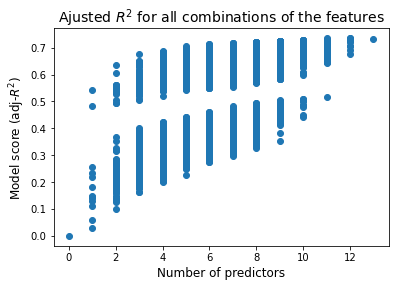

In [99]:
scorevalues=[np.array([(nr_var,scorehist[nr_var][val_idx]) for val_idx in range(len(scorehist[nr_var]))]) 
             for nr_var in range(len(scorehist))]

plt.scatter(np.vstack(scorevalues)[:,0],np.vstack(scorevalues)[:,1])
plt.xlabel("Number of predictors",fontsize=12)
plt.ylabel("Model score (adj-$R^2$)",fontsize=12)
plt.title("Ajusted $R^2$ for all combinations of the features",fontsize=14)
plt.show()

As can be observed, even if we are using an adjusted R-squared value, it still increases as the number of features increases.

## 7. Forward stepwise selection <a name="Forward"></a>

As we have seen, the problem with the best subset selection is that the number of model fitting is very high when the number of features is more than just a few. In order to decrease the number of model fitting drastically, the forward stepwise selection method is used. 

With this feature selection method, we start by fitting a model with none of the features (the model is the mean of the output). Then we use a simple linear regression model by using features one at a time and select the feature that provides the highest score. Next, we add a fit model by choosing a second feature from the available predictors not included in the model yet and choose the one which provides the highest score. We repeat this until the required number of features are selected.

In [100]:
# Calculate the adjusted R-squared value for the model with zero features (mean of the output)
y=boston['PRICE']
y_mean=y.mean()*np.ones(N)
scorehist=[]

r2=r2_score(y,y_mean)
r2_adj=1-(1-r2)*(N-1)/(N-D-1) if 1-(1-r2)*(N-1)/(N-D-1)>=0 else 0 # if it is negative set to zero
print('For %d variables '%0,end='')
print("the highest R-squred value is =",r2_adj)
print()
scorehist.append([r2_adj])

sum_models=1
R2_maxapprox=[r2_adj]
varselected=[]
for i in range(1,D+1):                    # loop for number of variables included
    R2_max=0
    idx=np.inf
    scores=[]
    var_notselected=[var for var in features if var not in varselected] 
    for var in var_notselected:           # loop for the variables not included yet in the selection
        sum_models+=1
        newvar=[]
        newvar.append(var)
        score=R2_adj_scorer(linregr,boston[varselected+newvar],y)
        scores.append(score)              # Save all the scores
        if score>R2_max:
            R2_max=score
            idx=list(features).index(var)
    varselected.append(list(features)[idx])
    R2_maxapprox.append(R2_max)
    scorehist.append(scores)
    print('For %d variables '%i,end='')
    print("the highest R-squared value is =",R2_max)
    print('\tfor variables',varselected)
    print()
print("Total number of model fit:",sum_models)

For 0 variables the highest R-squred value is = 0

For 1 variables the highest R-squared value is = 0.543241825954707
	for variables ['LSTAT']

For 2 variables the highest R-squared value is = 0.6371244754701231
	for variables ['LSTAT', 'RM']

For 3 variables the highest R-squared value is = 0.6767035874132712
	for variables ['LSTAT', 'RM', 'PTRATIO']

For 4 variables the highest R-squared value is = 0.6878351084841281
	for variables ['LSTAT', 'RM', 'PTRATIO', 'DIS']

For 5 variables the highest R-squared value is = 0.7051701822464959
	for variables ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX']

For 6 variables the highest R-squared value is = 0.712356667191387
	for variables ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS']

For 7 variables the highest R-squared value is = 0.7182560407158509
	for variables ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B']

For 8 variables the highest R-squared value is = 0.7222071804094558
	for variables ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 

As can be seen, the number of the model fitting is only 92 compared to the 8192 observed with the best subset selection.<br>
Let's create the scatter plot of the adjusted R-squared values on the top of the previous scatter plot for comparison.

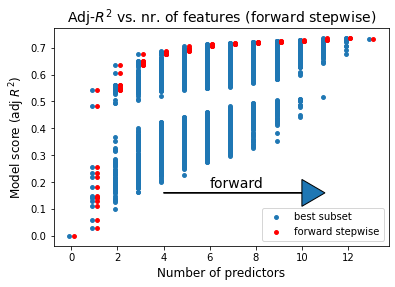

In [101]:
scorevaluesfw=[np.array([(nr_var,scorehist[nr_var][val_idx]) for val_idx in range(len(scorehist[nr_var]))]) 
               for nr_var in range(len(scorehist))]

plt.scatter(np.vstack(scorevalues)[:,0]-0.1,np.vstack(scorevalues)[:,1],s=15,label='best subset')
plt.scatter(np.vstack(scorevaluesfw)[:,0]+0.1,np.vstack(scorevaluesfw)[:,1],c='r',s=15,label='forward stepwise')
plt.xlabel("Number of predictors",fontsize=12)
plt.ylabel("Model score (adj $R^2$)",fontsize=12)
plt.title("Adj-$R^2$ vs. nr. of features (forward stepwise)",fontsize=14)
plt.arrow(x=4,y=0.16,dx=6,dy=0,head_width=0.1,head_length=1)
plt.text(x=6, y=0.18, s="forward",size=14)
plt.legend()
plt.show()

Although it may seem from the scatter plot that the forward stepwise selection always finds the maximum adjusted R-squared values, this is not the case. Let's print out the maximum R-squared obtained from the best subset selection, respective the ones obtained from the forward stepwise selection.

In [102]:
pd.DataFrame(data=np.vstack((np.array(R2_maxvals),np.array(R2_maxapprox))).T,\
             columns=['Absolute maximum adj-R2','Forward stepwise adj-R2'])

,Absolute maximum adj-R2,Forward stepwise adj-R2
0,0.000000,0.000000
1,0.543242,0.543242
2,0.637124,0.637124
3,0.676704,0.676704
4,0.687835,0.687835
5,0.705170,0.705170
6,0.712357,0.712357
7,0.718256,0.718256
8,0.722207,0.722207
9,0.725274,0.723905


And indeed, they differ for index 9 and 10.

However, the difference is minor, so we can state that the forward stepwise selection is a good approximation of the best subset selection method, while the required number of model fitting is much less.

## 8. Backward stepwise selection <a name="Backward"></a>

A similar approach is the backward stepwise selection method, but at this time, as the name suggests, you start from the full model with all the features selected. Then you drop features one by one, fitting a model each time with $D-1$ features, and chose the model with the highest adjusted R-squared value. Next, you drop predictors one by one again, fitting a model each time with $D-2$ features, and choose the model with the highest adjusted R-squared value. You keep doing this until you reach the predefined minimum number of features.

In [103]:
varselect=list(boston.columns[:-1])
scorehist=[]

score=R2_adj_scorer(linregr,boston[varselected+newvar],y)
scorehist.append([score])
print('For %d variables '%D,end='')
print("the highest R2 value is =",score)
print('\tfor variables',varselect)
print()

i=D-1
sum_models=1
R2_maxapprox=[score]
while len(varselect)>1:                    # loop until the number of included variables is zero
    R2_max=0
    idx=np.inf
    scores=[]
    for var in varselect:                  # loop through the variables included in the selection
        sum_models+=1
        newvar=varselect.copy()
        newvar.remove(var)
        score=R2_adj_scorer(linregr,boston[newvar],y)
        scores.append(score)              # Save all the scores
        if score>R2_max:
            R2_max=score
            idx=list(boston.columns).index(var)
    varselect.remove(list(boston.columns)[idx])
    R2_maxapprox.append(R2_max)
    print('For %d variables '%i,end='')
    print("the highest R2 value is =",R2_max)
    print('\tfor variables',varselect)
    print()
    scorehist.append(scores)
    i-=1

r2=r2_score(y,y_mean)
r2_adj=1-(1-r2)*(N-1)/(N-D-1) if 1-(1-r2)*(N-1)/(N-D-1)>=0 else 0 # if it is negative set to zero
scorehist.append([r2_adj])       
R2_maxapprox.append(r2_adj)
print('For %d variables '%0,end='')
print("the highest R-squred value is =",r2_adj)
print()
print("Total number of model fit:",sum_models)

For 13 variables the highest R2 value is = 0.7332475465891074
	for variables ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

For 12 variables the highest R2 value is = 0.7343282238499185
	for variables ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

For 11 variables the highest R2 value is = 0.7348057723274566
	for variables ['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

For 10 variables the highest R2 value is = 0.7299149280771853
	for variables ['CRIM', 'ZN', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

For 9 variables the highest R2 value is = 0.7243416235572313
	for variables ['CRIM', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

For 8 variables the highest R2 value is = 0.7195335672031167
	for variables ['CRIM', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO', 'B', 'LSTAT']

For 7 variables the highest R2 value is = 0.714786124980568


As can be seen, the number of the model fitting is only 91 compared to the 8192 observed with the best subset selection.<br>
Let's create the scatter plot of the adjusted R-squared values on the top of the scatter plot obtained for best subset selection for comparison.

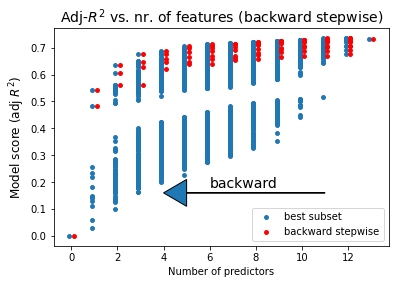

In [104]:
scorevaluesbw=[np.array([(13-nr_var,scorehist[nr_var][val_idx]) for val_idx in range(len(scorehist[nr_var]))],dtype=object) 
               for nr_var in range(len(scorehist))]

plt.scatter(np.vstack(scorevalues)[:,0]-0.1,np.vstack(scorevalues)[:,1],s=15,label='best subset')
plt.scatter(np.vstack(scorevaluesbw)[:,0]+0.1,np.vstack(scorevaluesbw)[:,1],c='r',s=15,label='backward stepwise')
plt.xlabel("Number of predictors")
plt.ylabel("Model score (adj $R^2$)",fontsize=12)
plt.title("Adj-$R^2$ vs. nr. of features (backward stepwise)",fontsize=14)
plt.arrow(x=11,y=0.16,dx=-6,dy=0,head_width=0.1,head_length=1)
plt.text(x=6, y=0.18, s="backward",size=14)
plt.legend()
plt.show()

From the scatter plot, it may seem that backward stepwise selection finds the maximum R-squared value, but this is not the case. We can check this by listing the R-squared values from the best subset selection together with the maximum R-squared values found by backward stepwise selection.

In [105]:
pd.DataFrame(data=np.vstack((np.array(R2_maxvals),np.array(R2_maxapprox)[::-1])).T,\
             columns=['Absolute maximum adj-R2','Backward stepwise adj-R2'])

,Absolute maximum adj-R2,Backward stepwise adj-R2
0,0.000000,0.000000
1,0.543242,0.543242
2,0.637124,0.637124
3,0.676704,0.676704
4,0.687835,0.687835
5,0.705170,0.705170
6,0.712357,0.711967
7,0.718256,0.714786
8,0.722207,0.719534
9,0.725274,0.724342


And indeed they differ for 6,7,8,9 number of variables. Nevertheless, the difference is minor.

You may also observe that the forward and backward stepwise selection methods may provide different results. For example, for six features we have:
- forward stepwise selection 'LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS'
- backward stepwise selection: 'NOX', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT'

## 9. Stepwise selection with cross-validation <a name="StepwiseCV"></a>

Slightly similar results can be obtained using the *scikit-learn* library. However, the *scikit-learn* library will choose the best feature set based on the cross-validation result and not on the maximum value of the adjusted R-squared with a model fitted on the whole data. Moreover, the *scikit-learn* library requires to provide in advance the number of features to be selected (either as an absolute number or as a percentile of the total predictors).

In [106]:
from sklearn.feature_selection import SequentialFeatureSelector

for i in range(1,boston.shape[1]-1):
    sfs = SequentialFeatureSelector(linregr,n_features_to_select=i,scoring=R2_adj_scorer,cv=5,direction='forward')
    sfs.fit(boston[features],boston['PRICE'])
    print('For %s variables the selected features are %s:'%(i,list(features[sfs.support_])))

For 1 variables the selected features are ['RM']:
For 2 variables the selected features are ['RM', 'LSTAT']:
For 3 variables the selected features are ['RM', 'AGE', 'LSTAT']:
For 4 variables the selected features are ['RM', 'AGE', 'B', 'LSTAT']:
For 5 variables the selected features are ['RM', 'AGE', 'TAX', 'B', 'LSTAT']:
For 6 variables the selected features are ['NOX', 'RM', 'AGE', 'TAX', 'B', 'LSTAT']:
For 7 variables the selected features are ['NOX', 'RM', 'AGE', 'RAD', 'TAX', 'B', 'LSTAT']:
For 8 variables the selected features are ['CRIM', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'B', 'LSTAT']:
For 9 variables the selected features are ['CRIM', 'CHAS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'B', 'LSTAT']:
For 10 variables the selected features are ['CRIM', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'B', 'LSTAT']:
For 11 variables the selected features are ['CRIM', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']:
For 12 variables the selected features are ['CRI

You may notice that even when only one feature is selected, the *scikit-learn* library chooses a different predictor. The reason is that while 'LSTAT' provides the maximum adjusted R-squared value with a model fitted on the whole dataset, that does not produce a better generalization score than using the 'RM' feature. Let's check this with K-fold cross-validation. 

In [107]:
from sklearn.model_selection import cross_validate
res=cross_validate(estimator=linregr,X=boston[['LSTAT']],y=boston['PRICE'],scoring={'R2-adj':R2_adj_scorer},cv=5)
print("Cross validated mean adjusted R-squared for 'LSTAT' is:",res['test_R2-adj'].mean())
res=cross_validate(estimator=linregr,X=boston[['RM']],y=boston['PRICE'],scoring={'R2-adj':R2_adj_scorer},cv=5)
print("Cross validated mean adjusted R-squared for 'RM' is:",res['test_R2-adj'].mean())

Cross validated mean adjusted R-squared for 'LSTAT' is: 0.48925727732555446
Cross validated mean adjusted R-squared for 'RM' is: 0.4901464813714897


As can be seen, with K-fold cross-validation, the mean of the adjusted R-squared value is slightly better for 'RM' than for 'LSTAT'.

Similarly we can use *scikit-learn* for backward stepwise selection.

In [108]:
from sklearn.feature_selection import SequentialFeatureSelector
SequentialFeatureSelector(estimator=LinearRegression())

for i in range(boston.shape[1]-2,0,-1):
    sfs = SequentialFeatureSelector(linregr,n_features_to_select=i,scoring=R2_adj_scorer,direction='backward')
    sfs.fit(boston[features],boston['PRICE'])
    print('For %s variables the selected features are %s:'%(i,list(features[sfs.support_])))

For 12 variables the selected features are ['CRIM', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']:
For 11 variables the selected features are ['CRIM', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']:
For 10 variables the selected features are ['CRIM', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'B', 'LSTAT']:
For 9 variables the selected features are ['CRIM', 'CHAS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'B', 'LSTAT']:
For 8 variables the selected features are ['CRIM', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'B', 'LSTAT']:
For 7 variables the selected features are ['CRIM', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'LSTAT']:
For 6 variables the selected features are ['CRIM', 'NOX', 'RM', 'RAD', 'TAX', 'LSTAT']:
For 5 variables the selected features are ['CRIM', 'NOX', 'RM', 'RAD', 'LSTAT']:
For 4 variables the selected features are ['NOX', 'RM', 'RAD', 'LSTAT']:
For 3 variables the selected features are ['NOX', 'RM', 'LSTAT']:
For 2 vari

## 10. Model selection with information criteria <a name="InfoCriteria"></a>

Even though we used adjusted R-square as a scoring function, which has some penalization on the number of features, we still ended up using all the predictors.

Another option is to use the Akaike Information Criteria (AIC) or Bayesian Information Criteria (BIC) as a model selection criteria. Based on the formula derived in the book, let's create a scorer for AIC.

In [109]:
def AIC_scorer(estimator,X,y):
    N,D=X.shape
    estimator.fit(X,y)
    SSE=N*mean_squared_error(y,estimator.predict(X))               # Error Sum of Squares
    llf=-N/2*np.log(2*np.pi)-N/2*np.log(SSE/N)-N/2                 # log-likelihood function
    return 2*(D+1)-2*llf                                           # AIC (assuming that X is an input matrix wo. const. term)

Similarly, we can create a scoring function based on the BIC using the formula derived in the book.

In [110]:
def BIC_scorer(estimator,X,y):
    N,D=X.shape
    estimator.fit(X,y)
    SSE=N*mean_squared_error(y,estimator.predict(X))               # Error Sum of Squares
    llf=-N/2*np.log(2*np.pi)-N/2*np.log(SSE/N)-N/2                 # log-likelihood function
    return np.log(N)*(D+1)-2*llf                                   # BIC (assuming that X is an input matrix wo. const. term)

Let's calculate the AIC for the Boston House-price dataset when all the predictors are used in the OLS.

In [111]:
AIC_scorer(linregr,boston[features],boston['PRICE'])

3025.608594075548

And compare with the AIC value provided by the *statsmodels* library as a check.

In [112]:
model.aic

3025.608594075548

Similarly, we can calculate the BIC value of the OLS for the Boston House-price dataset with all the predictors included.

In [113]:
BIC_scorer(linregr,boston[features],boston['PRICE'])

3084.7801074455724

And compare the result with the BIC value provided by the *statsmodels* library.

In [114]:
model.bic

3084.7801074455724

Now,  let's create a forward stepwise selection function. Using AIC or BIC as a scoring function, the model for which the minimum score is achieved is the best among all. 

For each number of features, we may also print out the selected features. We may also plot the minimum value of the information criteria for each number of predictors.

In [115]:
def forward(estimator,X,y,scorer):
    features=X.columns
    D=len(features)
    score_minapprox=[]
    varselected=[]
    for i in range(1,D+1):                    # loop for number of variables included
        score_min=np.inf
        idx=np.inf
        var_notselected=[var for var in features if var not in varselected] 
        for var in var_notselected:           # loop for the variables not included yet in the selection
            newvar=[]
            newvar.append(var)
            score=scorer(estimator,X[varselected+newvar],y)
            if score<score_min:
                score_min=score
                idx=list(features).index(var)
        varselected.append(list(features)[idx])
        print(i,varselected)
        score_minapprox.append(score_min)
    return score_minapprox,varselected

As an example, let's take the Boston House-price dataset using the AIC score for feature selection.

1 ['LSTAT']
2 ['LSTAT', 'RM']
3 ['LSTAT', 'RM', 'PTRATIO']
4 ['LSTAT', 'RM', 'PTRATIO', 'DIS']
5 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX']
6 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS']
7 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B']
8 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN']
9 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM']
10 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM', 'RAD']
11 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM', 'RAD', 'TAX']
12 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM', 'RAD', 'TAX', 'INDUS']
13 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM', 'RAD', 'TAX', 'INDUS', 'AGE']


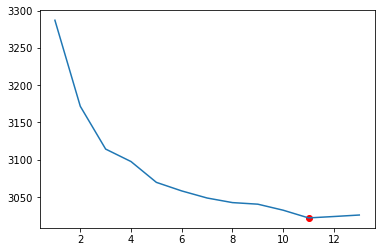

In [116]:
from sklearn.model_selection import train_test_split
features=boston.drop(['PRICE'],axis=1).columns
#X,Xt,y,yt=train_test_split(boston[features],boston[['PRICE']],test_size=0.2)
res,_=forward(estimator=linregr,X=boston[features],y=boston[['PRICE']],scorer=AIC_scorer)
plt.plot(np.arange(1,len(res)+1),res)
idx=np.argmin(res)
plt.scatter(idx+1,res[idx],c='r')
plt.show()

As can be seen, the minimum of the AIC is with a model with 11 features.<br>
The same result is obtained using the BIC.

1 ['LSTAT']
2 ['LSTAT', 'RM']
3 ['LSTAT', 'RM', 'PTRATIO']
4 ['LSTAT', 'RM', 'PTRATIO', 'DIS']
5 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX']
6 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS']
7 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B']
8 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN']
9 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM']
10 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM', 'RAD']
11 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM', 'RAD', 'TAX']
12 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM', 'RAD', 'TAX', 'INDUS']
13 ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'CHAS', 'B', 'ZN', 'CRIM', 'RAD', 'TAX', 'INDUS', 'AGE']


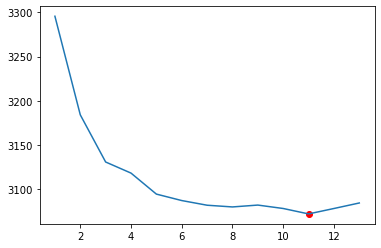

In [117]:
res,_=forward(estimator=linregr,X=boston[features],y=boston[['PRICE']],scorer=BIC_scorer)
plt.plot(np.arange(1,len(res)+1),res)
idx=np.argmin(res)
plt.scatter(idx+1,res[idx],c='r')
plt.show()

So far, so good.

If you remember, in Lab exercise 3.11, we realized that a polynomial regression of degree two with interaction term using only two from the original predictors provided a better model than the linear model with all the features included. Now, let's see what would be the outcome if we were to select from all possible combinations of the polynomial regression features.

In [118]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,include_bias=False)

Xp=poly.fit_transform(boston.drop(['PRICE'],axis=1))
Xp.shape

(506, 104)

As can be seen, the number of features is 104 instead of the 13 original features. To avoid overfitting, we need to select only a small subset of these features. With the forward stepwise selection, let's check the minimum AIC scores for each number of predictors (from 1 to 104).

In [119]:
df=pd.DataFrame(data=Xp,columns=poly.get_feature_names(features))
resAIC,_=forward(estimator=linregr,X=df,y=boston[['PRICE']],scorer=AIC_scorer)

1 ['PTRATIO LSTAT']
2 ['PTRATIO LSTAT', 'RM^2']
3 ['PTRATIO LSTAT', 'RM^2', 'RM']
4 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2']
5 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT']
6 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO']
7 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS']
8 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT']
9 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B']
10 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX']
11 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX']
12 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT']
13 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', '

39 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS']
40 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM']
41 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTR

55 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2']
56 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS L

68 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2', 'RAD TAX', 'ZN RAD', 'INDUS', 'INDUS RM', 'CRIM RAD', 'INDUS^2', 'TAX^2', 'DIS RAD', 'INDUS TAX', 'INDUS DIS', 'CHAS LSTAT', 'CHAS AGE', 'CHAS B']
69 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS

79 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2', 'RAD TAX', 'ZN RAD', 'INDUS', 'INDUS RM', 'CRIM RAD', 'INDUS^2', 'TAX^2', 'DIS RAD', 'INDUS TAX', 'INDUS DIS', 'CHAS LSTAT', 'CHAS AGE', 'CHAS B', 'AGE DIS', 'NOX RAD', 'RM B', 'ZN NOX', 'ZN RM', 'B LSTAT', 'LSTAT', 'NOX', 'ZN INDUS', 'NOX TAX', 'ZN CHAS']
80 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', '

88 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2', 'RAD TAX', 'ZN RAD', 'INDUS', 'INDUS RM', 'CRIM RAD', 'INDUS^2', 'TAX^2', 'DIS RAD', 'INDUS TAX', 'INDUS DIS', 'CHAS LSTAT', 'CHAS AGE', 'CHAS B', 'AGE DIS', 'NOX RAD', 'RM B', 'ZN NOX', 'ZN RM', 'B LSTAT', 'LSTAT', 'NOX', 'ZN INDUS', 'NOX TAX', 'ZN CHAS', 'CHAS DIS', 'ZN B', 'NOX^2', 'CRIM AGE', 'CRIM DIS', 'NOX B', 'INDUS B', 'CRIM INDUS', 'CRIM']
89 ['PTRATIO LSTAT', 'RM^2

97 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2', 'RAD TAX', 'ZN RAD', 'INDUS', 'INDUS RM', 'CRIM RAD', 'INDUS^2', 'TAX^2', 'DIS RAD', 'INDUS TAX', 'INDUS DIS', 'CHAS LSTAT', 'CHAS AGE', 'CHAS B', 'AGE DIS', 'NOX RAD', 'RM B', 'ZN NOX', 'ZN RM', 'B LSTAT', 'LSTAT', 'NOX', 'ZN INDUS', 'NOX TAX', 'ZN CHAS', 'CHAS DIS', 'ZN B', 'NOX^2', 'CRIM AGE', 'CRIM DIS', 'NOX B', 'INDUS B', 'CRIM INDUS', 'CRIM', 'INDUS RAD', 'PTRATIO B', 

Let's plot the minimum AIC values for each number of predictors, respective the overall minimum value of the AIC.

Number of features with minimum AIC:  64


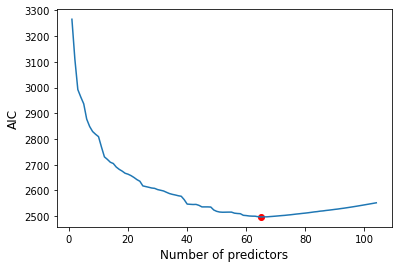

In [120]:
plt.plot(np.arange(1,len(resAIC)+1),resAIC)
idxAIC=np.argmin(resAIC)
print("Number of features with minimum AIC: ", idxAIC)
plt.scatter(idxAIC+1,resAIC[idxAIC],c='r')
plt.xlabel("Number of predictors",fontsize=12)
plt.ylabel("AIC",fontsize=12)
plt.show()

As can be seen, the automatically selected feature number is 64, which is almost two-thirds of the total number of features.

Let's do the same with BIC.

In [121]:
resBIC,_=forward(estimator=linregr,X=df,y=boston[['PRICE']],scorer=BIC_scorer)

1 ['PTRATIO LSTAT']
2 ['PTRATIO LSTAT', 'RM^2']
3 ['PTRATIO LSTAT', 'RM^2', 'RM']
4 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2']
5 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT']
6 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO']
7 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS']
8 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT']
9 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B']
10 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX']
11 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX']
12 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT']
13 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', '

39 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS']
40 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM']
41 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTR

55 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2']
56 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS L

68 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2', 'RAD TAX', 'ZN RAD', 'INDUS', 'INDUS RM', 'CRIM RAD', 'INDUS^2', 'TAX^2', 'DIS RAD', 'INDUS TAX', 'INDUS DIS', 'CHAS LSTAT', 'CHAS AGE', 'CHAS B']
69 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS

79 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2', 'RAD TAX', 'ZN RAD', 'INDUS', 'INDUS RM', 'CRIM RAD', 'INDUS^2', 'TAX^2', 'DIS RAD', 'INDUS TAX', 'INDUS DIS', 'CHAS LSTAT', 'CHAS AGE', 'CHAS B', 'AGE DIS', 'NOX RAD', 'RM B', 'ZN NOX', 'ZN RM', 'B LSTAT', 'LSTAT', 'NOX', 'ZN INDUS', 'NOX TAX', 'ZN CHAS']
80 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', '

88 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2', 'RAD TAX', 'ZN RAD', 'INDUS', 'INDUS RM', 'CRIM RAD', 'INDUS^2', 'TAX^2', 'DIS RAD', 'INDUS TAX', 'INDUS DIS', 'CHAS LSTAT', 'CHAS AGE', 'CHAS B', 'AGE DIS', 'NOX RAD', 'RM B', 'ZN NOX', 'ZN RM', 'B LSTAT', 'LSTAT', 'NOX', 'ZN INDUS', 'NOX TAX', 'ZN CHAS', 'CHAS DIS', 'ZN B', 'NOX^2', 'CRIM AGE', 'CRIM DIS', 'NOX B', 'INDUS B', 'CRIM INDUS', 'CRIM']
89 ['PTRATIO LSTAT', 'RM^2

98 ['PTRATIO LSTAT', 'RM^2', 'RM', 'LSTAT^2', 'NOX LSTAT', 'DIS PTRATIO', 'CRIM CHAS', 'CRIM LSTAT', 'RAD B', 'RM TAX', 'TAX', 'TAX LSTAT', 'AGE B', 'DIS^2', 'DIS TAX', 'RM PTRATIO', 'DIS', 'NOX RM', 'NOX PTRATIO', 'CRIM NOX', 'DIS LSTAT', 'CRIM RM', 'RM LSTAT', 'DIS B', 'AGE RAD', 'RAD LSTAT', 'NOX DIS', 'AGE LSTAT', 'RM DIS', 'PTRATIO', 'CRIM PTRATIO', 'INDUS AGE', 'INDUS LSTAT', 'TAX PTRATIO', 'INDUS PTRATIO', 'AGE TAX', 'INDUS NOX', 'CHAS NOX', 'CHAS', 'CHAS RM', 'CRIM^2', 'CHAS PTRATIO', 'ZN LSTAT', 'ZN TAX', 'ZN PTRATIO', 'ZN DIS', 'CRIM B', 'B', 'AGE', 'RM AGE', 'NOX AGE', 'B^2', 'ZN^2', 'CRIM ZN', 'RAD^2', 'RAD TAX', 'ZN RAD', 'INDUS', 'INDUS RM', 'CRIM RAD', 'INDUS^2', 'TAX^2', 'DIS RAD', 'INDUS TAX', 'INDUS DIS', 'CHAS LSTAT', 'CHAS AGE', 'CHAS B', 'AGE DIS', 'NOX RAD', 'RM B', 'ZN NOX', 'ZN RM', 'B LSTAT', 'LSTAT', 'NOX', 'ZN INDUS', 'NOX TAX', 'ZN CHAS', 'CHAS DIS', 'ZN B', 'NOX^2', 'CRIM AGE', 'CRIM DIS', 'NOX B', 'INDUS B', 'CRIM INDUS', 'CRIM', 'INDUS RAD', 'PTRATIO B', 

Let's plot the minimum BIC values for each number of predictors, respective the overall minimum value of the BIC.

Number of features with minimum BIC:  39


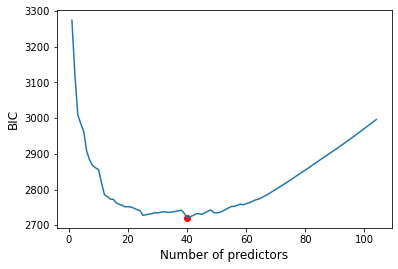

In [122]:
plt.plot(np.arange(1,len(resBIC)+1),resBIC)
idxBIC=np.argmin(resBIC)
print("Number of features with minimum BIC: ", idxBIC)
plt.scatter(idxBIC+1,resBIC[idxBIC],c='r')
plt.xlabel("Number of predictors",fontsize=12)
plt.ylabel("BIC",fontsize=12)
plt.show()

As can be seen, the BIC provides a less complex model with only 39 features. Moreover, the BIC value is almost the same for around 25 predictors, which is only 25% of the total number of features.

As a reminder, let's print out the OLS result from Lab exercise 3.11 Polynomial Regression using only two from the original features. 

In [123]:
model = ols(formula = 'PRICE ~ RM + LSTAT + np.square(RM) + RM:LSTAT + np.square(LSTAT)', data=boston).fit()
print(model.summary(title='Polynomial regression with two original features'))
print("\nRMSE =",np.sqrt(model.mse_resid))

               Polynomial regression with two original features               
Dep. Variable:                  PRICE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     312.0
Date:                Mon, 15 Nov 2021   Prob (F-statistic):          3.79e-151
Time:                        21:04:38   Log-Likelihood:                -1482.0
No. Observations:                 506   AIC:                             2976.
Df Residuals:                     500   BIC:                             3001.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           61.0081     15.696  

We may observe that for five features, both AIC and BIC selected the same feature set. Let's fit the OLS using these predictors for comparison.

In [124]:
model = ols(formula = 'PRICE ~ PTRATIO:LSTAT + np.square(RM) + RM + np.square(LSTAT) + NOX:LSTAT', data=boston).fit()
print(model.summary(title='Linear regression with 5 predictors selected by BIC'))
print("\nRMSE =",np.sqrt(model.mse_resid))

             Linear regression with 5 predictors selected by BIC              
Dep. Variable:                  PRICE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     345.4
Date:                Mon, 15 Nov 2021   Prob (F-statistic):          1.35e-159
Time:                        21:04:38   Log-Likelihood:                -1462.3
No. Observations:                 506   AIC:                             2937.
Df Residuals:                     500   BIC:                             2962.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          104.3084      9.430  

As can be seen, although the selected polynomial features are different, the goodness of fit scores are around the same. But with automatic selection, the model is slightly better, and all the selected predictors have regression coefficients statistically different from zero.

A better model can be obtained if we use nine predictors. As a comparison, here is polynomial regression from Lab exercise 3.11 using three from the original predictors.

In [125]:
model = ols(formula = 'PRICE ~ RM+PTRATIO+LSTAT+np.square(RM)+RM:PTRATIO+RM:LSTAT+np.square(PTRATIO)+PTRATIO:LSTAT+\
np.square(LSTAT)', data=boston).fit()
print(model.summary(title='Polynomial regression with three original features'))
print("\nRMSE =",np.sqrt(model.mse_resid))

              Polynomial regression with three original features              
Dep. Variable:                  PRICE   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     215.8
Date:                Mon, 15 Nov 2021   Prob (F-statistic):          2.99e-165
Time:                        21:04:39   Log-Likelihood:                -1437.4
No. Observations:                 506   AIC:                             2895.
Df Residuals:                     496   BIC:                             2937.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -155.8150     37

While the OLS result using nine predictors selected with information criteria is:

In [126]:
model = ols(formula = 'PRICE ~ PTRATIO:LSTAT+np.square(RM)+RM+np.square(LSTAT)+NOX:LSTAT+DIS:PTRATIO+CRIM:CHAS+CRIM:LSTAT+\
RAD:B', data=boston).fit()
print(model.summary(title='Linear regression with 9 predictors selected by BIC'))
print("\nRMSE =",np.sqrt(model.mse_resid))

             Linear regression with 9 predictors selected by BIC              
Dep. Variable:                  PRICE   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     259.9
Date:                Mon, 15 Nov 2021   Prob (F-statistic):          1.98e-181
Time:                        21:04:39   Log-Likelihood:                -1399.2
No. Observations:                 506   AIC:                             2818.
Df Residuals:                     496   BIC:                             2861.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           94.0154      8.519  

In this case, the difference is more prominent.

Finally, let's check the automatic feature selection with information criteria for the KC-HouseSale dataset. Here, again print out the OLS results with reduced predictors obtained earlier for comparison.

In [127]:
formula='price ~ ' + ' + '.join(numvar_shortlist) +' + ' + ' + '.join(catvar_shortlist)
model_ols1 = ols(formula = formula, data=data).fit()
print(model_ols1.summary(title="OLS Regression Results (reduced number of predictors)"))
print("RMSE =",np.sqrt(model_ols1.mse_resid))

            OLS Regression Results (reduced number of predictors)             
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     6013.
Date:                Mon, 15 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:04:39   Log-Likelihood:            -2.9495e+05
No. Observations:               21613   AIC:                         5.899e+05
Df Residuals:                   21604   BIC:                         5.900e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.705e+07   4.93e+05    -54.859      

Then using the forward stepwise regression with BIC scoring, let's see what would be the feature selection result.

1 ['sqft_living']
2 ['sqft_living', 'lat']
3 ['sqft_living', 'lat', 'view']
4 ['sqft_living', 'lat', 'view', 'grade']
5 ['sqft_living', 'lat', 'view', 'grade', 'age']
6 ['sqft_living', 'lat', 'view', 'grade', 'age', 'waterfront']
7 ['sqft_living', 'lat', 'view', 'grade', 'age', 'waterfront', 'bedrooms']
8 ['sqft_living', 'lat', 'view', 'grade', 'age', 'waterfront', 'bedrooms', 'bathrooms']
9 ['sqft_living', 'lat', 'view', 'grade', 'age', 'waterfront', 'bedrooms', 'bathrooms', 'zipcode']
10 ['sqft_living', 'lat', 'view', 'grade', 'age', 'waterfront', 'bedrooms', 'bathrooms', 'zipcode', 'long']
11 ['sqft_living', 'lat', 'view', 'grade', 'age', 'waterfront', 'bedrooms', 'bathrooms', 'zipcode', 'long', 'condition']
12 ['sqft_living', 'lat', 'view', 'grade', 'age', 'waterfront', 'bedrooms', 'bathrooms', 'zipcode', 'long', 'condition', 'sqft_above']
13 ['sqft_living', 'lat', 'view', 'grade', 'age', 'waterfront', 'bedrooms', 'bathrooms', 'zipcode', 'long', 'condition', 'sqft_above', 'spring_s

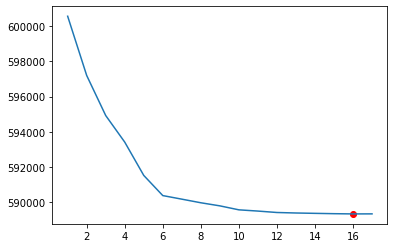

In [128]:
res,_=forward(estimator=linregr,X=data[numvar_list+catvar_list],y=data[['price']],scorer=BIC_scorer)
plt.plot(np.arange(1,len(res)+1),res)
idx=np.argmin(res)
plt.scatter(idx+1,res[idx],c='r')
plt.show()

As can be seen, the automatic selection for the number of features is 16. However, above ten predictors, the BIC does not decrease significantly. If we check the set of features selected for eight predictors, we realize it is the same as what we intuitively obtained earlier. 

<img src = "images/AML1-Cover.png" width = 110, align = "left" style="margin:0px 20px">

<span style="color:blue">**Note:**</span> This Jupyter Notebook is accompanying the book: <br> $\qquad$ <b>Advanced Machine Learning Made Easy</b> <br> $\qquad$ From Theory to Practice with NumPy and scikit-learn <br> $\qquad$ <i> Volume 1: Generalized Linear Models</i><br>
by Ferenc Farkas, Ph.D. 

If you find this Notebook useful, please support me by buying the book at [Leanpub](http://leanpub.com/AML1). <br>
Copyright notice: This Jupyter Notebook is made available under the [MIT License](https://opensource.org/licenses/MIT).